pygame 2.3.0 (SDL 2.24.2, Python 3.10.10)
Hello from the pygame community. https://www.pygame.org/contribute.html
<========== Example Usages ===========> 
<Environment Info>

{'height': 8, 'width': 8, 'init_agent_pos': (2, 1), 'init_agent_dir': array([ 0, -1]), 'door_pos': array([4, 1]), 'goal_pos': array([5, 1]), 'key_pos': array([3, 2])}
<================>



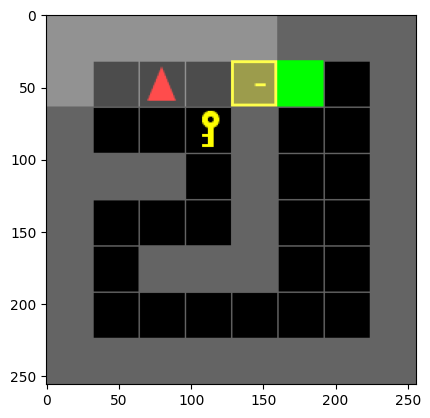

Moving Forward Costs: 0
Turning Left Costs: 0
Turning Right Costs: 0
Picking Up Key Costs: 0
Unlocking Door Costs: 0
Step Count: 5


In [1]:
from utils import *
from example import example_use_of_gym_env
from doorkey import *
import glob


In [24]:
class doorkey:
    def __init__(self, env_path: str):
        self._env_path = env_path
        self._env, self._info = env, info = load_env(env_path)  # load an environment
        self._motion_dict = { 
            'MF': 0,  # Move Forward
            'TL': 1,  # Turn Left
            'TR': 2,  # Turn Right
            'PK': 3,  # Pickup Key
            'UD': 4  # Unlock Door
        }
        self._H = info['height']
        self._W = info['width']
        self._T = info['height'] * info['width']
        self._S = np.array([info['init_agent_pos'][0], info['init_agent_pos'][1]])
        self._TAU = np.array([info['goal_pos'][0], info['goal_pos'][1]])
        self._MAP = np.zeros((info['height'], info['width']))
        self._map_index = map_index = {'door_closed': 1, 'key': 2, 'goal': 3, 'wall': 4}
        self._dir = {'up': [0, -1], 'down': [0, 1], 'left': [-1, 0], 'right': [1, 0]}
        self._key_pos = None
        self._pick_key_pos = []
        self._DP = None
        self._pos_seq = []
        self._motion = []


    def __get_motion__(self):
        return self._motion

    def __create_map__(self):
        for h in range(self._H ):
            for w in range(self._W):
                if (self._env.grid.get(w, h) != None):
                    if (self._env.grid.get(w, h).type == 'door'):
                        if (self._env.grid.get(w, h).is_open == False):
                            self._MAP[h, w] = self._map_index['door_closed']
                    elif (self._env.grid.get(w, h).type == 'key'):
                        self._key_pos = np.array([w, h])
                        self._MAP[h, w] = self._map_index['key']
                    else:
                        self._MAP[h, w] = self._map_index[self._env.grid.get(w, h).type]

    def __create_pick_key_pos__(self):
        if (self._key_pos.all() != None):
            for _ , next_dir in self._dir.items():
                next_pos = np.array([self._key_pos[0] + next_dir[0], self._key_pos[1] + next_dir[1]])
                if (0 <= next_pos[0] < self._W and 0 <= next_pos[1] < self._H and 
                self._MAP[next_pos[1], next_pos[0]] != self._map_index['door_closed'] and 
                self._MAP[next_pos[1], next_pos[0]] != self._map_index['wall']):
                    self._pick_key_pos.append(next_pos)

    def __key_not_required__(self, is_open: bool, source: list, dest: list):
        DP = np.zeros((self._H, self._W))
        motion_map = np.zeros((self._H, self._W, 2))

        # First step.
        for h in range(self._H):
            for w in range(self._W):
                if (w != source[0] or h != source[1]):
                    DP[h, w] = np.Inf

        # Remaining step.
        for t in range(self._T):
            DP_temp = DP.copy()

            for h in range(self._H):
                for w in range(self._W):
                    for next_move , next_dir in self._dir.items():
                        next_pos = np.array([w + next_dir[0], h + next_dir[1]])
                        if (0 <= next_pos[0] < self._W and 0 <= next_pos[1] < self._H and 
                        (self._MAP[next_pos[1], next_pos[0]] != self._map_index['door_closed'] or is_open) and 
                        self._MAP[next_pos[1], next_pos[0]] != self._map_index['wall']):
                            if (DP[next_pos[1], next_pos[0]] > DP_temp[h, w] + 1):
                                DP[next_pos[1], next_pos[0]] = DP_temp[h, w] + 1
                                motion_map[next_pos[1], next_pos[0]] = np.array([w, h]).astype(int)

            # terminate condition.
            if ((DP == DP_temp).all()):
                break

        seq = []

        # Create sequence step.
        if (DP[dest[1], dest[0]] != np.Inf): 
            curr = dest.astype(int)
            seq.append(curr)
            while ((curr == source).all() == False):
                seq.append(motion_map[curr[1], curr[0]].astype(int))
                curr = motion_map[curr[1], curr[0]].astype(int)

            seq.reverse()
        return DP, seq

    def __key_required__(self):
        DP1, DP2 = None, None
        seq1, seq2 = None, None
        final_pick_key_pos = None
        step = np.Inf

        # Crompare all the potential pick key pos.
        for pos in self._pick_key_pos:
            DP1_temp, seq1_temp = self.__key_not_required__(False, self._S, pos)
            DP2_temp, seq2_temp = self.__key_not_required__(True, pos, self._TAU)

            if (DP1_temp[pos[1], pos[0]] + DP2_temp[self._TAU[1], self._TAU[0]] < step):
                DP1 = DP1_temp
                DP2 = DP2_temp
                seq1 = seq1_temp
                seq2 = seq2_temp
                final_pick_key_pos = pos
                step = DP1_temp[pos[1], pos[0]] + DP2_temp[self._TAU[1], self._TAU[0]]
                
        return DP1[final_pick_key_pos[1], final_pick_key_pos[0]] + DP2, seq1 + seq2

    def __pos_planning__(self):
        key_not_required_step = np.Inf
        key_required_step = np.Inf

        DP_wo_key, seq_wo_key = self.__key_not_required__(False, self._S, self._TAU)
        key_not_required_step = DP_wo_key[self._TAU[1], self._TAU[0]]

        if (len(self._pick_key_pos) != 0):
            DP_w_key, seq_w_key  = self.__key_required__()
            key_required_step = DP_w_key[self._TAU[1], self._TAU[0]]

        if (key_not_required_step <= key_required_step):
            print("no key required")
            return DP_wo_key, seq_wo_key
        else:
            print("key required")
            return DP_w_key, seq_w_key

    def __move__(self, move: str):
        cost, done = step(self._env, self._motion_dict[move])  # MF=0, TL=1, TR=2, PK=3, UD=4
        self._motion.append(self._motion_dict[move])
        # plot_env(self._env)

    def __change_dir__(self, source: list, dest: list):
        agent_pos = self._env.agent_pos
        agent_dir = self._env.dir_vec 

        pos_diff = dest - source
        ori_diff = agent_dir - pos_diff

        x = ori_diff[0]
        y = ori_diff[1]

        # Move the orientaion.
        if (x == 0 and y == 0):
            # Move.
            pass
        elif (x * y == 0):
            # Turn back.
            self.__move__('TR')
            self.__move__('TR')
        elif (x * y > 0):
            if (agent_dir[1] != 0):
                # Turn right.
                self.__move__('TR')
            else:
                # Turn left.
                self.__move__('TL')          
        elif (x * y < 0):
            if (agent_dir[0] != 0):
                # Turn right.
                self.__move__('TR')
            else:
                # Turn left.
                self.__move__('TL')


    def __motion_planning__(self):
        self.__create_map__()
        self.__create_pick_key_pos__()
        self._DP, self._pos_seq = self.__pos_planning__()

        p = 0
        n = len(self._pos_seq)
        done = False

        curr_pos = self._pos_seq[p]
        p += 1

        while (p < n and done == False):
            # Find the next position.
            next_pos = self._pos_seq[p]
  
            # Check whether the agent should turn the orientation.
            if ((curr_pos == next_pos).all()):
                self.__change_dir__(curr_pos, self._key_pos)

                self.__move__('PK')
                p += 1
            else:
                agent_pos = self._env.agent_pos
                agent_dir = self._env.dir_vec 

                pos_diff = next_pos - curr_pos
                ori_diff = agent_dir - pos_diff

                x = ori_diff[0]
                y = ori_diff[1]

                # Move the orientaion.
                if (x == 0 and y == 0):
                    # Move.
                    pass
                elif (x * y == 0):
                    # Turn back.
                    self.__move__('TR')
                    self.__move__('TR')
                elif (x * y > 0):
                    if (agent_dir[1] != 0):
                        # Turn right.
                        self.__move__('TR')
                    else:
                        # Turn left.
                        self.__move__('TL')          
                elif (x * y < 0):
                    if (agent_dir[0] != 0):
                        # Turn right.
                        self.__move__('TR')
                    else:
                        # Turn left.
                        self.__move__('TL')
            
                
                # Get next cell status.
                front_cell = self._env.front_pos  # == agent_pos + agent_dir
                cell = self._env.grid.get(front_cell[0], front_cell[1])  # NoneType, Wall, Key, Goal

                if (cell != None):
                    if (cell.type == 'door'):
                        # Door.
                        if (cell.is_open == False):
                            if (self._env.carrying != None):
                                self.__move__('UD')
                                self.__move__('MF')
                                p += 1
                            else:
                                pass
                        else:
                            self.__move__('MF')
                            p += 1
                            pass  

                    elif (cell.type == 'key'):
                        pass

                    elif (cell.type == 'goal'):
                        self.__move__('MF')
                        p += 1
                    else:
                        #  Wall.
                        pass
                else:
                    self.__move__('MF')
                    p += 1

                curr_pos = next_pos

        self._motion.append(0)
    
    def __all__(self):
        plot_env(self._env)
        self.__motion_planning__()
        seq = self.__get_motion__()  # Find the optimal action sequence.
        
        name = self._env_path.split(".")[1].split('/')[-1]
        draw_gif_from_seq(seq, load_env(self._env_path)[0], path="./gif/{}.gif".format(name))  # draw a GIF & save


        

In [25]:
def main():
    known_envs = glob.glob("./envs/known_envs/*.env")
    known_envs.sort()
    # env_path = "./envs/known_envs/doorkey-6x6-normal.env"
    # env_path = "./envs/random_envs/DoorKey-8x8-16.env"

    for env_path in known_envs:
        dk = doorkey(env_path)
        dk.__all__()

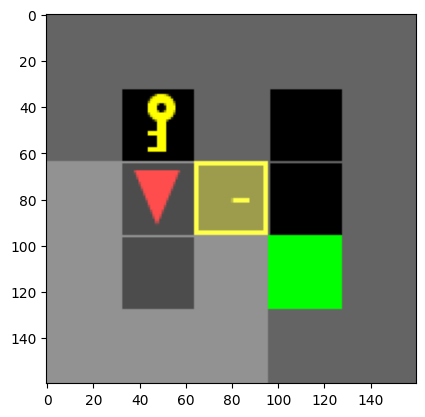

3.0 inf
key required
[2, 2, 3, 2, 4, 0, 0, 2, 0, 0]
GIF is written to ./gif/doorkey-5x5-normal.gif


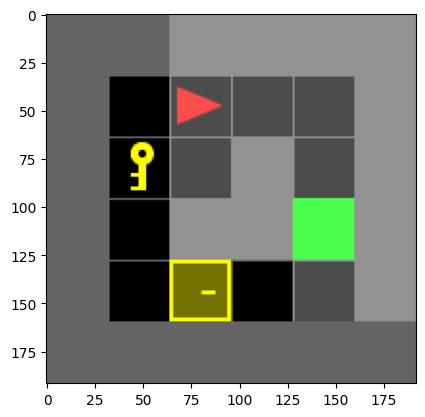

6.0 4.0
no key required
[0, 0, 2, 0, 0, 0]
GIF is written to ./gif/doorkey-6x6-direct.gif


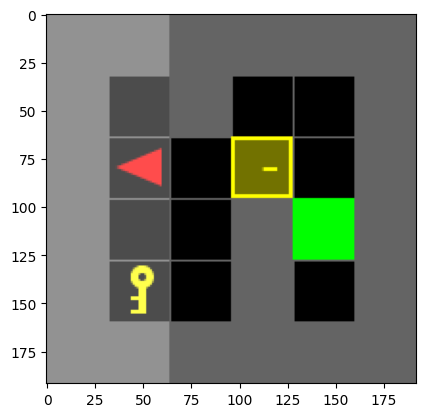

6.0 inf
key required
[1, 0, 3, 2, 2, 0, 2, 0, 4, 0, 0, 2, 0, 0]
GIF is written to ./gif/doorkey-6x6-normal.gif


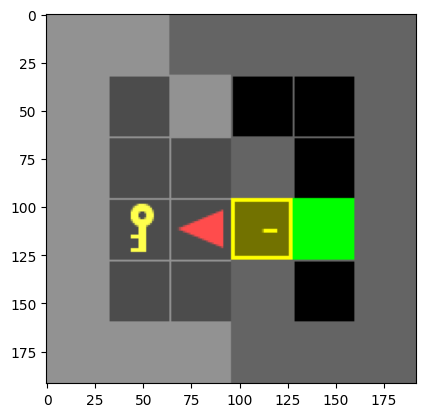

2.0 inf
key required
[3, 2, 2, 4, 0, 0, 0]
GIF is written to ./gif/doorkey-6x6-shortcut.gif


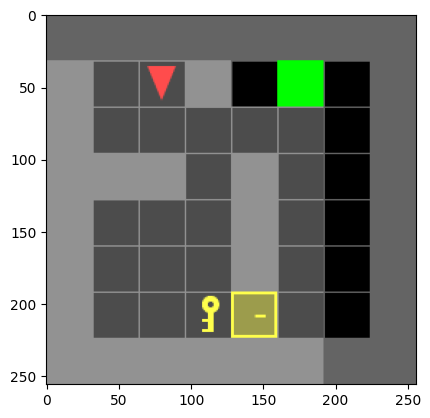

11.0 5.0
no key required
[0, 1, 0, 0, 1, 0, 2, 0, 0]
GIF is written to ./gif/doorkey-8x8-direct.gif


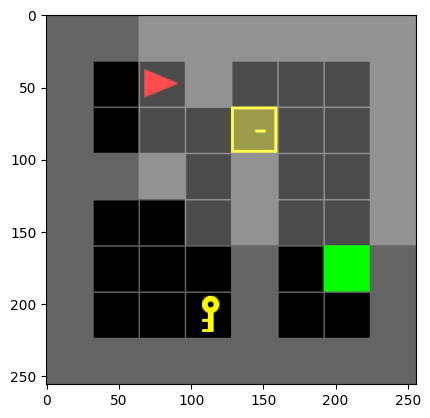

14.0 inf
key required
[2, 0, 1, 0, 2, 0, 0, 0, 3, 2, 2, 0, 0, 0, 2, 4, 0, 0, 0, 2, 0, 0, 0, 0]
GIF is written to ./gif/doorkey-8x8-normal.gif


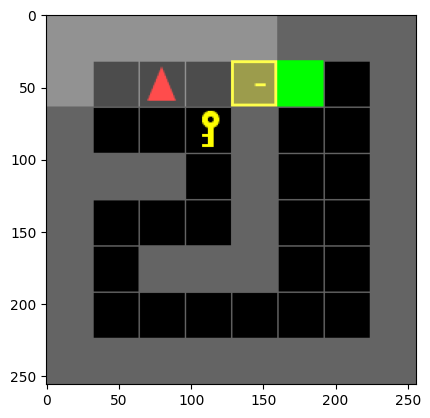

3.0 17.0
key required
[2, 0, 2, 3, 1, 4, 0, 0, 0]
GIF is written to ./gif/doorkey-8x8-shortcut.gif


In [26]:
main()

In [ ]:
self._motion_dict = { 
    'MF': 0,  # Move Forward
    'TL': 1,  # Turn Left
    'TR': 2,  # Turn Right
    'PK': 3,  # Pickup Key
    'UD': 4  # Unlock Door
}